In [40]:
#Adapted from the Keras Example https://keras.io/examples/structured_data/collaborative_filtering_movielens/

In [41]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Week 6.1- Embeddings for Recommendation 

Here we'll see how to train our simple **Dot Product** model, along with our **user embeddings** and **item embeddings** using the **Keras** library. As before, we'll be checking out the **MovieLens** dataset 

## Loading in the Dataset

First we load in the small version of the dataset. As this is a **Collaborative Filtering** approach, we are interested in the **ratings.csv**, which has all over ratings made by each user.

In [42]:
df = pd.read_csv("data/ml-latest-small/ratings.csv")

In [43]:
len(df)

100004

In [44]:
df.tail(100)

,userId,movieId,rating,timestamp
99904,671,590,4.0,1065149296
99905,671,608,4.0,1064890575
99906,671,745,4.0,1065149085
99907,671,919,4.0,1065149458
99908,671,1035,5.0,1065149492
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


## Preprocessing 

What we have in the dataset is a list of **userId** and **movieId** pairs loaded into a ``Pandas`` DataFrame. 

As we said before, you can think of an embedding layer as a **one-hot encoding** layer the size of your **vocabulary**, followed by a **fully connected layer** the size of your embedding. 

When we make the embedding, we will need a way of mapping back from **indexes** in the **one-hot encoding** back to the ids for the users and movies. 

### Vocabulary 

In order to make the vocabulary (all the unique ids), we can use the ``unique()`` function in ``Pandas``

In [45]:
user_ids = df["userId"].unique().tolist()
movie_ids = df["movieId"].unique().tolist()

In [46]:
len(movie_ids)

9066

In [47]:
#Non-sequential list of ids
movie_ids[:6]

[31, 1029, 1061, 1129, 1172, 1263]

### Dictionary Comprehensions 

We've seen ``Dictionaries`` (e.g. when looking at JSON from REST APIs). This is a collection like a ``List``, but instead of using indexes to access data (**values**), we use **keys**. 

We've also seen ``List Comprehensions``, a short hand way to iterate through an existing collection and make a new ``List``. 

As we want something where we can use an arbitrary string/number (e.g. a movie or user id) to look up an index, a ``Dictionary`` seems like a good data structure to use. We can declare dictionaries manually (see below), but it would be much quicker and cleaner to use the information we already have to make this.


In [48]:
#Manually making the dictionary
movie_id_to_index = {
    31: 1,
    1029: 2,
    1061: 3
}
#Use a movie id to look up an index
movie_id_to_index[31]

1

Like the ``List Comprehension``, the ``Dictionary Comprehension`` iterates through a given collection, does some calculation and stores new values in a new collection. 

In this case, we need to return both a ``Key`` and a ``Value`` for each item. 

```
a = [1,2,3]
b = {i:i+1 for i in a} 
```

is the same as 

```
a = [1,2,3]
b = {}
for i in a:
    b[i] = i+1
```

where we end up with the ``Dictionary``

```
{
    1: 2,
    2: 3,
    3: 4
}
```

Below, we combine the dictionary comprehension with the ``enumerate()`` function to return the id (x) and the index (i) and store them in a new dictionary 

In [49]:
#Make a dictionary mapping ids (keys) to indexes (values)
user_id_to_index = {x: i for i, x in enumerate(user_ids)}
movie_id_to_index = {x: i for i, x in enumerate(movie_ids)}

In [50]:
#Make a new column in the dataframe which contains the appropriate index for each user and movie
df["user_index"] = [user_id_to_index[i] for i in df["userId"]]
df["movie_index"] = [movie_id_to_index[i] for i in df["movieId"]]

In [51]:
df.head(5)

,userId,movieId,rating,timestamp,user_index,movie_index
0,1,31,2.5,1260759144,0,0
1,1,1029,3.0,1260759179,0,1
2,1,1061,3.0,1260759182,0,2
3,1,1129,2.0,1260759185,0,3
4,1,1172,4.0,1260759205,0,4


### Scaling the ratings

As is good when working with ``gradient descent``, it helps to have our values on a similar range, and for that to be between 0 and 1. We can use the ``MinMaxScaler`` from ``Scikit-Learn`` to scale our ratings to between 0 and 1

In [52]:
df["rating"].describe()

count    100004.000000
mean          3.543608
std           1.058064
min           0.500000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [53]:
from sklearn.preprocessing import MinMaxScaler
##Pick the range\
df["rating"] = MinMaxScaler().fit_transform(df["rating"].values.reshape(-1, 1))

In [54]:
df["rating"].describe()

count    100004.000000
mean          0.676357
std           0.235125
min           0.000000
25%           0.555556
50%           0.777778
75%           0.777778
max           1.000000
Name: rating, dtype: float64

## Training Set

We are making a **predictive model** that will take a **user** and **movie** and return a **rating**. 

For our training, we will make a dataset using the information we already know. In this context, our input feautres (``x``) are the movie and user indexes, and the our output (``y``) is the rating. 

We make a train - test split of ``10%`` to validate our model. 

In [55]:
from sklearn.model_selection import train_test_split
#Inputs
x = df[["user_index", "movie_index"]]
#Outputs
y = df["rating"]
#Get train-test split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=42)

## Making a Custom Model 

Previously in ``Keras`` we have used to pre-existing layers, connecting them all together in using the [Sequential](https://keras.io/guides/sequential_model/) object. This allows us to fit together layers that pass information forwards in a structure that works for most **Neural Networks**.

Partly for reasons of broadening our horizons, and partly due to many Tensorflow based issues, we are going to introduce you to what is fastly becoming the most popular machine learning library, ``PyTorch``. 

Luckily for us, the API (the functions, the structure of models etc..) are very similar across a lot of the leading libraries.

``PyTorch`` has a [Module]() object which we can **subclass**. Without getting too bogged down in the details of **Object Oriented Programming**, essentially what this means is we can take the **existing functionality** from this object and **override** certain functions to add in custom behaviour.

Using the ``Module`` structure, we have something that can take advantage of a lot the things that are built into the ``PyTorch`` library. It can be trained, can have layers, can have parameters that can be optimised.

**But**, we can also add in our own functionality. 

The two main functions we want to override and these are 

1. ``def __init__()``
    
    * This is called **once** when the object is first made. We can use this to define our layers 
    

2. ``def forward()``

    * This is called everytime we want to make a forwards pass. This means it takes some **inputs** and returns some **outputs**. This is called during training, or for inference on a trained model. 
    
### LouisNet

Below, we show an **incredibly simple model**, but it should help you get an intuition for what function is called at when in the training process

We can see the ``__init__()`` is called once, and then the ``call()`` is called **once per batch**, where we get the inputs for this batch and return some outputs

This model doesnt actually have any parameters to train, its more to demonstrate the subclassing principle in the simplest terms

In [56]:
#Install libraries (only do this once!)
!pip install torch torchvision torchaudio

In [57]:
#import library
import torch

In [58]:
#Define class and subclass torch.nn.Module
class LouisNet(torch.nn.Module):
    
    #Override __init__()
    def __init__(self):
        super().__init__()
        print("__init__ called")
    
    #Override forward()
    def forward(self, inputs):
        print("\nforwards pass (new batch)")
        print(inputs,"\n")
        #return the output (its just the input, unchanged)
        return inputs

#Make a new instance of LouisNet    
louisNet = LouisNet()
loss_fn = torch.nn.MSELoss() 

#Fake dataset
x = torch.FloatTensor([[1],[2],[3],[4]])
y = torch.FloatTensor([[2],[3],[4],[5]])

#Do a forwards pass
prediction = louisNet(x)
loss = loss_fn(prediction, y)

__init__ called

forwards pass (new batch)
tensor([[1.],
        [2.],
        [3.],
        [4.]]) 



## The Dot Product Recommender Model

Lets remember the model we're trying to make. 


```
Predicted Rating = Dot Product(user_vector, item_vector) + user_bias + item_bias
```


Our target is to find a vector for each movie and user so that their dot product (+ their biases) is an accurate prediction for the rating that user would make for that movie. 

Each of these vectors will be contained in a matrix, that we call an **embedding**


### The Embedding Layer 

Again, you can think of an embedding layer as a **one-hot encoding** layer the size of your **vocabulary**, followed by a **fully connected layer** the size of your embedding. 

Luckily, ```PyTorch``` has a layer already we can use, all we have to say is 

1. How many items we have (vocabulary size)

2. The size of the embedding 

You might use something between 10-300, and this is something you will have to tune

### New Arguments for ``__init__``

Again, we will override the ```__init__()``` function, but this time we will add in some extra arguments. We can use this to pass in 

1. Number of users 

2. Number of movies

3. Size of Embedding

These get passed in when we make the new object 

```
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)

```

### Saving Variables and ```self```

Finally, the last **Object-oriented** concept we'll need allows us to save things within the object. These are sometimes called ``instance variables`` or ``fields``, but the main thing you need to know is **these are like the variables we use all the time to store objects and data**, apart from they belong to the object, and only work within this context 

We use the keyword ```self``` within the object to refer to itself. We can use this to make layers in the ```__init__()``` function, store them in the object, and then reuse and update them in the ```forward()``` function.


On every forwards pass (see ``forward()`` below)

1. We take a batch of ``users`` and ``movies``


2. Run them through the normal embedding and bias embedding layers respectively 


3. Get the vectors for each out 


4. Get the dot product of the user and movie vectors 


5. Add the biases 


6. Run through a sigmoid


7. Return!

In [59]:
class RecommenderNet(torch.nn.Module):
    def __init__(self, num_users, num_movies, embedding_size=20):
        super().__init__()
        self.user_embedding = torch.nn.Embedding(num_users, embedding_size)
        self.user_bias = torch.nn.Embedding(num_users, 1)
        self.movie_embedding = torch.nn.Embedding(num_movies, embedding_size)
        self.movie_bias = torch.nn.Embedding(num_movies, 1)
        self.sig = torch.nn.Sigmoid()

    def forward(self, inputs):
        #Split out indexes 
        user_indexes = inputs[:, 0]
        movie_indexes = inputs[:, 1]
        #Forward pass on embedding layer
        user_vector = self.user_embedding(user_indexes)
        user_bias = self.user_bias(user_indexes).flatten()
        movie_vector = self.movie_embedding(movie_indexes)
        movie_bias = self.movie_bias(movie_indexes).flatten()
        #Dot product
        dot = (user_vector * movie_vector).sum(1)
        with_bias = dot + user_bias + movie_bias
        #Activation function
        output = self.sig(with_bias)
        return output

## Lets test it!

### Set up model

In [60]:
#Pick Embedding size
EMBEDDING_SIZE = 16
#Make new object (calls __init__())
num_users = len(user_ids)
num_movies = len(movie_ids)
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)

### Training and Datasets in PyTorch

PyTorch requires a little bit of manual set up for the training loop that we got for free in ``Keras`` with the ``fit()`` function. 

Below we see two for loops, one that loops round every epoch (once through the entire dataset) and inside that that loops through each batch (a subset of a chosen size).

``PyTorch`` gives us a ``DataLoader`` object which helps with the batching process.

Within that inner loop we pass in part of the training set, calculate the loss and update the weights based on this. 


In [61]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

#Make a subclass to hold our dataset (movie - user pairs (input) and a rating (label))
class MoviesDataset(Dataset):
    def __init__(self, X,y):
        self.X = torch.IntTensor(X)
        self.y = torch.FloatTensor(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [62]:
#Use our train - validation split to make DataLoader objects
train_dl = DataLoader(MoviesDataset(x_train.values,y_train.values), batch_size=64, shuffle=True)
validation_dl = DataLoader(MoviesDataset(x_val.values,y_val.values), batch_size=64, shuffle=True)

In [63]:
epochs = 50
#Use Mean Squared Error as a loss function
loss_fn = torch.nn.MSELoss() 
#Use the Adam algorithm to update the weights based on the loss
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [64]:
#Use a for loop to repeat for the desired number of epochs 
for i in range(epochs):
    
    model.train(True)
    
    #Use a for loop for each batch (provided by the Dataloader)
    running_loss = 0.0
    for (index, batch) in enumerate(train_dl):
        
        #Get batch 
        inputs, labels = batch
        model.zero_grad()
        
        #Forward pass
        prediction = model(inputs)
        
        #Get Loss
        loss = loss_fn(prediction, labels)
        
        #Update weights (back prop)
        loss.backward()
        optimizer.step()
        running_loss += loss
    
    avg_loss = running_loss / (index + 1)

    model.train(False)

    #Now try with the validation set (no need to update weights, just get loss)
    running_vloss = 0.0
    for index, vdata in enumerate(validation_dl):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (index + 1)
    print('Loss {} Validation Loss {}'.format(avg_loss, avg_vloss))

Loss 0.23541203141212463 Validation Loss 0.22670796513557434
Loss 0.2081894874572754 Validation Loss 0.2096940577030182
Loss 0.1826946884393692 Validation Loss 0.19390146434307098
Loss 0.16037294268608093 Validation Loss 0.1795358955860138
Loss 0.14128504693508148 Validation Loss 0.16702309250831604
Loss 0.1251065582036972 Validation Loss 0.15592673420906067
Loss 0.11146674305200577 Validation Loss 0.14639152586460114
Loss 0.09987993538379669 Validation Loss 0.1372392326593399
Loss 0.08975902199745178 Validation Loss 0.12975051999092102
Loss 0.08101294189691544 Validation Loss 0.12242931872606277
Loss 0.07327497005462646 Validation Loss 0.11664103716611862
Loss 0.06650833040475845 Validation Loss 0.11165235936641693
Loss 0.06067853793501854 Validation Loss 0.10699781030416489
Loss 0.055567216128110886 Validation Loss 0.10295537114143372
Loss 0.05107441917061806 Validation Loss 0.09934910386800766
Loss 0.04714213311672211 Validation Loss 0.09638157486915588
Loss 0.043662164360284805 Val

### Accessing the Embeddings 

We can access the **embedding layers** in our model object. This is the embedding and we can see is has a shape of ```num_users x EMBEDDING_SIZE```

In [65]:
torch.save(model.state_dict(), 'model_weights.pth')

In [66]:
num_users, EMBEDDING_SIZE, model.user_embedding

(671, 16, Embedding(671, 16))

### Making Predictions 

Now, we can use our trained model to make predictions, and with the predicted ratings, we can pick some recommendations!

In order to get the ratings for all movies for a given user, we need to get pass in our data in the form 

```
[
    [user_index, movie_1_index],
    [user_index, movie_2_index],
    [user_index, movie_3_index],
    .....
]

```

In [67]:
#Get the movie data so we can map back to names
movie_data = pd.read_csv("data/ml-latest-small/movies.csv")
movie_data.columns

Index(['movieId', 'title', 'genres'], dtype='object')

### Making predictions and `argsort()`

Once we have the predicted ratings for each film, we need to get the **Top N**

Here we use `np.argsort()`, which does the sort based on the **ratings** but returns the **indexes** rather than the **ratings themselves**. We can then use this to look up the `movie_ids` and then the `title`.

In [68]:
def get_top_n(user = 0, n = 10):
    #For one user, make a pair with every movie index
    x = torch.IntTensor([[user, i] for i in np.arange(num_movies)])
    #Predict 
    predicted_ratings = model(x)
    #Get Top-N indexes
    top_n_indexes = predicted_ratings.argsort()[-n:]
    #Get Movie Names
    top_n = [movie_data[movie_data["movieId"]==movie_ids[i]]["title"].item() for i in top_n_indexes]
    return top_n

In [69]:
#Random users top 10
get_top_n(np.random.randint(num_users))

['Firestarter (1984)',
 'Lords of Flatbush, The (1974)',
 'Return of Martin Guerre, The (Retour de Martin Guerre, Le) (1982)',
 'Victoria (2015)',
 'Cruise, The (1998)',
 'Baraka (1992)',
 'Cutting Edge, The (1992)',
 'Admission (2013)',
 'Snoopy Come Home (1972)',
 'Communion (1989)']

# Assessed Assignment 2

Please remember to comment your code clearly, submit ``.ipynb`` 

## Task 1

We're going to ask you take the trained model and write the code to make two metrics - **Diversity** and **Novelty**. You should end up with **one statistic** for each that tells you something about the recommendations of the trained model based on the **whole dataset**.


#### Pro Tip

This will take quite a long time to run on the whole dataset, so start off by trying to get the code to work for **one user**, then expand to **two users**, then **every user**.

### Diversity 

This tells us what the mean diversity (inverse of the similarity, based on movie embeddings) between each film in every users Top 10 films is. 

1. Calculate every user's top 10


2. For each top 10, get the embedding for each film then use this to calculate the similarity matrix


3. Invert similarity to get the difference


4. Get mean difference for each top 10 


5. Report the mean for whole dataset (every top 10)


### Novelty 

This tells us what the mean popularity (e.g. mean rating) of the films in every users Top 10 films is 

1. Calculate every user's top 10


2. For each top 10, get the mean rating for each film (based on the original **MovieLens Small** dataset (``df = pd.read_csv("ml-latest-small/ratings.csv")``). 


3. Get the mean rating for each top 10.


4. Report the mean for the whole dataset (every top 10).



## Task 2

Using a dimensionality reduction approach (PCA? TSNE?), plot the top 30 best rated films on a 2-D graph based on their movie embeddings. Label each point with the title.



In [70]:
#Task 1

In [71]:
def get_movie_embeddings(movie_data, movie_ids, model):
    #Convert movie_ids to movie_indexes using the dictionary built before
    movie_indexes = torch.tensor([movie_id_to_index[movie_id] for movie_id in movie_ids])
    # Get the embeddings of these movie indexes from the model
    movie_embeddings = model.movie_embedding(movie_indexes).detach().numpy()
    return movie_embeddings

In [72]:
from sklearn.metrics.pairwise import cosine_similarity
# Get a random user index
user_index = np.random.randint(num_users)

In [73]:
def diversity(user_index, n=10):
    # Get the top 10 movie titles for a user
    top_10_movie_titles = get_top_n(user_index, n)
    # Convert movie titles to movie_ids
    top_10_movie_ids = [movie_data[movie_data["title"]==title]["movieId"].item() for title in top_10_movie_titles]
    # Get the movie embeddings for the top 10 movies
    movie_embeddings = get_movie_embeddings(movie_data, top_10_movie_ids, model)
    # Get cosine distances between all pairs of movie embeddings
    similarities = cosine_similarity(movie_embeddings)
    # Calculate differences by (1 - similarities)
    differences = 1 - similarities
    mean_difference = np.mean(differences)
    return mean_difference

In [74]:
def novelty(user_index, n=10):
    # Get the top 10 movie titles for a user
    top_10_movie_titles = get_top_n(user_index, n)
    # Convert movie titles to movie_ids
    top_10_movie_ids = [movie_data[movie_data["title"]==title]["movieId"].item() for title in top_10_movie_titles]
    # Get the mean rating for each top 10
    mean_rating = df[df['movieId'].isin(top_10_movie_ids)]['rating'].mean()
    return mean_rating

In [75]:
def calculate():
    # Get the unique user IDs from the DataFrame
    unique_user_ids = df['userId'].unique()
    # Creates lists to store diversity and novelty scores for each user
    diversity_scores = []
    novelty_scores = []
    # Iterate through each unique user ID
    for user_id in unique_user_ids:
        # Get the user index corresponding to the user ID
        user_index = user_id_to_index[user_id]
        # Get the diversity score for this user using the diversity function
        each_diversity = diversity(user_index, n=10)
        # Get the novelty score for this user using the novelty function
        each_novelty = novelty(user_index, n=10)
        # Add the calculated diversity and novelty scores to their respective lists
        diversity_scores.append(each_diversity)
        novelty_scores.append(each_novelty)
    # Calculate the mean diversity and novelty scores of the whole dataset
    mean_diversity = np.mean(diversity_scores)
    mean_novelty = np.mean(novelty_scores)
    # Print the mean diversity and novelty scores
    print("Mean Diversity:", mean_diversity)
    print("Mean Novelty:", mean_novelty)

In [76]:
# Call the calculate function to compute the mean diversity and novelty scores
calculate()

Mean Diversity: 0.5783468
Mean Novelty: 0.7362607304854712


In [77]:
#Task 2 PCA Visualisation

In [78]:
from sklearn.decomposition import PCA

In [82]:
# Group the DataFrame by the 'movieId' and calculate the mean rating for each movie
mean_ratings = df.groupby('movieId')['rating'].mean()

# Identify the top 30 best rated films
top_30_movie_ids = mean_ratings.nlargest(30).index
top_30_movie_indexes = [movie_id_to_index[movie_id] for movie_id in top_30_movie_ids]

# Extract the movie embeddings for the top films
top_30_movie_embeddings = model.movie_embedding(torch.tensor(top_30_movie_indexes)).detach().numpy()

#Reduce dimensions
pca = PCA(n_components=2)
reduced_top_30_movie_embeddings = pca.fit_transform(top_30_movie_embeddings)

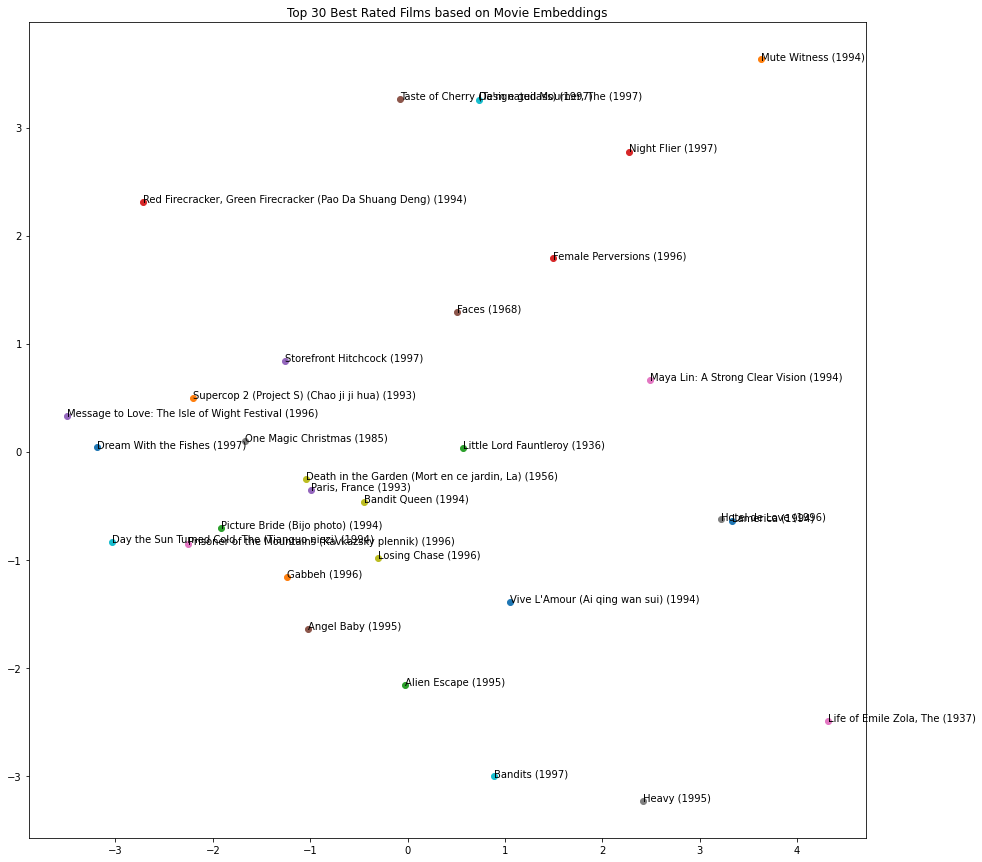

In [84]:
# Plot the reduced embeddings on a 2D graph and label each point with the movie title
plt.figure(figsize=(15, 15))
for i, movie_index in enumerate(top_30_movie_indexes):
    x, y = reduced_top_30_movie_embeddings[i]
    plt.scatter(x, y)
    plt.text(x, y, movie_data[movie_data["movieId"] == movie_ids[movie_index]]["title"].item(), fontsize=10)

plt.title('Top 30 Best Rated Films based on Movie Embeddings')
plt.show()